In [ ]:
# Folder to store our data
%mkdir data
# data file train.csv manually uploaded to this directory

# Data load, exploration and visualization

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split

def read_twitter_data(data_dir='./data/train.csv'):
    train_df = pd.read_csv(data_dir)
    
    raw_data = train_df['text']
    raw_labels = train_df['target']
    
    # shuffle and split our data and labels
    X_train, X_test, y_train, y_test = train_test_split(raw_data, raw_labels, random_state=42, stratify=raw_labels)
    
    # split our training set in a smaller training set and a validation set for hyperparameter tuning
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=61, stratify=y_train)
    
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    
    sets = ['train', 'test', 'validation']
    label = ['disaster', 'no_disaster']
    
    data = {}
    labels = {}
    
    for subset in sets:    
        data[subset] = {}
        labels[subset] = {}
    
        for label in labels:
            data[subset][label] = []
            labels[subset][label] = []
    
    data['train']['disaster'] = X_train[y_train==1]
    labels['train']['disaster'] = y_train[y_train==1]
    
    data['train']['no_disaster'] = X_train[y_train==0]
    labels['train']['no_disaster'] = y_train[y_train==0]
    
    data['test']['disaster'] = X_test[y_test==1]
    labels['test']['disaster'] = y_test[y_test==1]
    
    data['test']['no_disaster'] = X_test[y_test==0]
    labels['test']['no_disaster'] = y_test[y_test==0]
    
    data['validation']['disaster'] = X_test[y_test==1]
    labels['validation']['disaster'] = y_test[y_test==1]
    
    data['validation']['no_disaster'] = X_test[y_test==0]
    labels['validation']['no_disaster'] = y_test[y_test==0]
                
    return data, labels, X_train, X_test, X_val, y_train, y_test, y_val

In [60]:
data, labels, X_train, X_test, X_val, y_train, y_test, y_val = read_twitter_data()

We now plot some descriptive stats on the datasets and show some sample rows

In [61]:
# some sample rows from our data train and labels:
print('Data: \n', X_train.head(5))
print('Labels: \n', y_train.head(5))

Data: 
 0    @cwheate hahaha I'm half traumatised half hopi...
1    Truck crash on 40w at US70 in Lebanon is a fat...
2    Tension In Bayelsa As Patience Jonathan Plans ...
3    Nike Golf Storm Fit Golf Jacket Black Medium h...
4    Listening to Blowers and Tuffers on the Aussie...
Name: text, dtype: object
Labels: 
 0    0
1    1
2    1
3    0
4    0
Name: target, dtype: int64


In [62]:
# an example from a random tweet
X_train[100]

# Notice the special use of @ symbols and #, we will have to clean that later

'@DougMartin17 Fireman Ed runs into burning buildings while others are running out Doug he deserves your respect??????'

In [63]:
# show we split our data
print('There are {} rows in train'.format(X_train.shape[0]))
print('There are {} rows in test'.format(X_test.shape[0]))
print('There are {} rows in validation'.format(X_val.shape[0]))
print('Train to (Train + Test) size: ',X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))

There are 4281 rows in train
There are 1904 rows in test
There are 1428 rows in validation
Train to (Train + Test) size:  0.6921584478577203


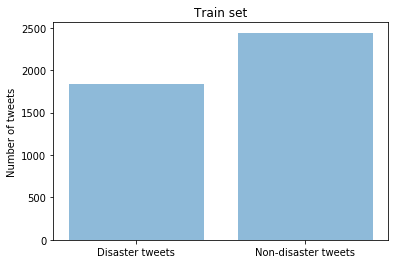

In [122]:
# show data distribution
import matplotlib.pyplot as plt

plt.bar(x=['Disaster tweets','Non-disaster tweets'], 
        height=[len(y_train[y_train==1]), len(y_train[y_train==0])], align='center', alpha=0.5)
plt.title('Train set')
plt.ylabel('Number of tweets')
plt.show()

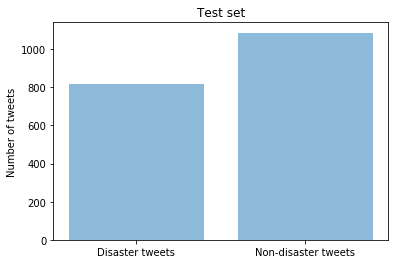

In [123]:
# show data distribution
plt.bar(x=['Disaster tweets','Non-disaster tweets'], 
        height=[len(y_test[y_test==1]), len(y_test[y_test==0])], align='center', alpha=0.5)
plt.title('Test set')
plt.ylabel('Number of tweets')
plt.show()

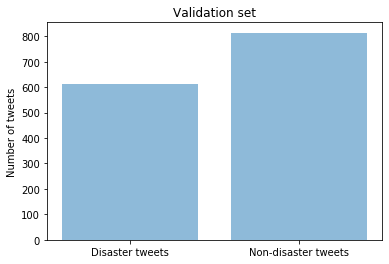

In [124]:
# show data distribution
plt.bar(x=['Disaster tweets','Non-disaster tweets'], 
        height=[len(y_val[y_val==1]), len(y_val[y_val==0])], align='center', alpha=0.5)
plt.title('Validation set')
plt.ylabel('Number of tweets')
plt.show()

We observe there is a class distribution in both datasets, but there is enough data from both classifications for it not to be a problem when training and testing our model.

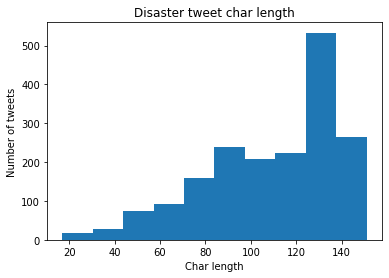

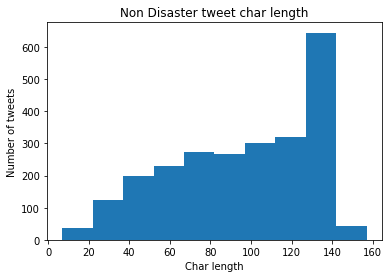

In [126]:
# exploratory analysis

plt.hist(X_train[y_train==1].str.len())
plt.title('Disaster tweet char length')
plt.ylabel('Number of tweets')
plt.xlabel('Char length')
plt.show()
plt.hist(X_train[y_train==0].str.len())
plt.title('Non Disaster tweet char length')
plt.ylabel('Number of tweets')
plt.xlabel('Char length')
plt.show()

We can see that in both cases most tweets have between 80 and 150 characters. But how many words are usually in a tweet?

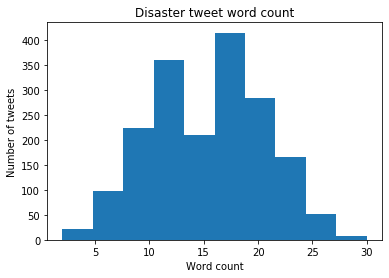

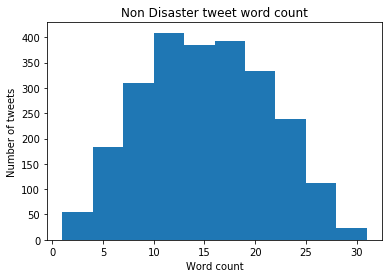

In [127]:
plt.hist(X_train[y_train==1].str.split().map(lambda x: len(x)))
plt.title('Disaster tweet word count')
plt.ylabel('Number of tweets')
plt.xlabel('Word count')
plt.show()
plt.hist(X_train[y_train==0].str.split().map(lambda x: len(x)))
plt.title('Non Disaster tweet word count')
plt.ylabel('Number of tweets')
plt.xlabel('Word count')
plt.show()

We see most tweets are under the 30 word mark, this is information we will use later for padding our data.

# Data Preprocessing

Now we clean our data and split into words in the same way as we did for the sentiment model

In [69]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def tweet_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [70]:
# we can see how it workds for the tweet we looked at before
print(tweet_to_words(X_train[100]))

['dougmartin17', 'fireman', 'ed', 'run', 'burn', 'build', 'other', 'run', 'doug', 'deserv', 'respect']


Now pre-process the data and store it in cache to avoid repeating the preprocessing

In [72]:
import os
import pickle

cache_dir = os.path.join("./cache", "tweet_data")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, data_val, labels_train, labels_test, labels_val,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = [tweet_to_words(tweet) for tweet in data_train]
        words_test = [tweet_to_words(tweet) for tweet in data_test]
        words_val = [tweet_to_words(tweet) for tweet in data_val]
        
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test, words_val=words_val,
                              labels_train=labels_train, labels_test=labels_test, labels_val=labels_val)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, words_val, labels_train, labels_test, labels_val = (cache_data['words_train'],
                cache_data['words_test'], cache_data['words_val'], cache_data['labels_train'], cache_data['labels_test'],
                                                                                    cache_data['labels_val'])
    
    return words_train, words_test, words_val, labels_train, labels_test, labels_val

In [73]:
train_X, test_X, val_X, train_y, test_y, val_y = preprocess_data(X_train, X_test, X_val, y_train, y_test, y_val)

Wrote preprocessed data to cache file: preprocessed_data.pkl


# Implementation

We can now use this data to create a vocabulary, saving a classification for "no word" and "infrequent words", something we also did in the sentiment project

In [74]:
import numpy as np
from collections import Counter

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""

    # First create a flatlist from all of the data reviews
    flat_list = []
    for sublist in data:
        for item in sublist:
            flat_list.append(item)
    
    word_count = dict(Counter(flat_list)) # A dict storing the words that appear in the reviews along with how often they occur
    
    sorted_word_dict = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True)) # order the dict by most appearing first
    sorted_words = list(sorted_word_dict.keys()) # get keys of the ordered dictionary
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [75]:
word_dict = build_dict(train_X)

In [76]:
# We can explore the most common words in tweets
print(list(word_dict.keys())[0:5])

['co', 'http', 'like', 'fire', 'get']


Notice there are some strange words present:
- `http` as it is common to share links in tweets. We will leave it in the vocabulary, maybe sharing a link is or is not a signal that a disaster is ongoing.
- `fire` is also a common word in our vocabulary, but it may or may not refer to a literal fire.

In [55]:
# save our dictionary
data_dir = './data/pytorch' # The folder we will use for storing data


In [56]:
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

Now we proceed the converting our tweets to numerical labels using our dictionary and padding our data. In this case we set the padding to 30 words as we saw it covered most cases of our training data

In [77]:
def convert_and_pad(word_dict, sentence, pad=30):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=30):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [78]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)
val_X, val_X_len = convert_and_pad_data(word_dict, val_X)

In [79]:
print('train_X[100]: \n', train_X[100])
print('length of train_X[100]: \n', len(train_X[100]))
print('Review length of train_X[100]: \n', train_X_len[100])

train_X[100]: 
 [4174 2752 2753   90   13   26  856   90 4175 2111 1450    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
length of train_X[100]: 
 30
Review length of train_X[100]: 
 11


In [80]:
# save data locally
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)

In [25]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

In [26]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [27]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [28]:

pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


# Initial model

We begin with initial hyperparameters: epochs = 5; hidden_dim = 200.

In [29]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 5,
                        'hidden_dim': 200,
                    })

In [30]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-03-04 23:11:59 Starting - Starting the training job...
2021-03-04 23:12:01 Starting - Launching requested ML instances.........
2021-03-04 23:13:34 Starting - Preparing the instances for training......
2021-03-04 23:14:48 Downloading - Downloading input data...
2021-03-04 23:15:20 Training - Downloading the training image......
2021-03-04 23:16:19 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-04 23:16:20,013 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-04 23:16:20,040 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-04 23:16:20,044 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-04 23:17:16,429 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-03-04 23:17:16,429

In [31]:
# deploy
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!

In [32]:
import pandas as pd
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [33]:
# We split the data into chunks and send each chunk separately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [34]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [35]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.6612394957983193

In [36]:
# compute F1 score
from sklearn.metrics import f1_score
f1_score(test_y, predictions)

0.5697131420947298

In [37]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.


# Refinement

In [ ]:
# We make hyperparameter tuning based on the epochs parameter

In [88]:
import torch
import torch.utils.data
import pandas as pd
import os

train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None)
validation_sample = pd.read_csv(os.path.join(data_dir, 'validation.csv'), header=None, names=None)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Turn the validation pandas dataframe into tensors
validation_sample_y = torch.from_numpy(validation_sample[[0]].values).float().squeeze()
validation_sample_X = torch.from_numpy(validation_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
validation_sample_ds = torch.utils.data.TensorDataset(validation_sample_X, validation_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)
validation_sample_dl = torch.utils.data.DataLoader(validation_sample_ds, batch_size=validation_sample_ds.__len__())

In [99]:
def train(model, train_loader, epochs, optimizer, loss_fn, device, validation_loader):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Using pyTorch example from: https://pytorch.org/docs/stable/optim.html
            optimizer.zero_grad()
            output = model(batch_X)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
          
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))
        
        # Try the model with our validation set and calculate the F1 score
        for batch2 in validation_loader:
            batch2_X, batch2_y = batch2
            batch2_X = batch2_X.to(device)
            batch2_y = batch2_y.to(device)
            pred_y = model(batch2_X)
            print('F1 score: ',f1_score(validation_sample[[0]], np.round(pred_y.detach().numpy())))

In [102]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 20, optimizer, loss_fn, device, validation_sample_dl)

Epoch: 1, BCELoss: 0.6608889574228332
F1 score:  0.5673998871968414
Epoch: 2, BCELoss: 0.6195751463257989
F1 score:  0.6293103448275862
Epoch: 3, BCELoss: 0.5643271342959515
F1 score:  0.6943722943722944
Epoch: 4, BCELoss: 0.5030629932880402
F1 score:  0.7490764421710714
Epoch: 5, BCELoss: 0.4469327871189561
F1 score:  0.7816091954022989
Epoch: 6, BCELoss: 0.40092829441608385
F1 score:  0.8140252454417953
Epoch: 7, BCELoss: 0.3582931685932847
F1 score:  0.8340237503452085
Epoch: 8, BCELoss: 0.3146708344304284
F1 score:  0.856115107913669
Epoch: 9, BCELoss: 0.2834772680734479
F1 score:  0.8633333333333334
Epoch: 10, BCELoss: 0.2523863881306593
F1 score:  0.8917890157694399
Epoch: 11, BCELoss: 0.2175551934470964
F1 score:  0.9083990214732265
Epoch: 12, BCELoss: 0.1881117857992649
F1 score:  0.9264501804052179
Epoch: 13, BCELoss: 0.17229210910235726
F1 score:  0.9231210556511761
Epoch: 14, BCELoss: 0.1585004786679218
F1 score:  0.9104829210836277
Epoch: 15, BCELoss: 0.13797878014833428
F1

The highest F1 score was with 19 epochs, so we will use this as our new hyperparameter and refine our initial model

# Refined Model

In [103]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 19,
                        'hidden_dim': 200,
                    })

In [104]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-03-05 00:17:54 Starting - Starting the training job...
2021-03-05 00:17:56 Starting - Launching requested ML instances......
2021-03-05 00:19:11 Starting - Preparing the instances for training.........
2021-03-05 00:20:27 Downloading - Downloading input data...
2021-03-05 00:21:16 Training - Downloading the training image...
2021-03-05 00:21:38 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-05 00:21:39,773 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-05 00:21:39,800 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-05 00:21:39,804 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-05 00:21:40,129 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-03-05 00:21:40,130 sagem

In [105]:
predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

In [106]:
import pandas as pd
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [108]:
# We split the data into chunks and send each chunk separately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [109]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [110]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.7305672268907563

In [111]:
# compute F1 score
from sklearn.metrics import f1_score
f1_score(test_y, predictions)

0.6644865925441464

In [112]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.


We see improvement on the F1 score calculated using the test set

# Benchmark model

In [ ]:
# benchmark model

In [113]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model

In [117]:
# we use the same data inputs for our benchmark model
train_X, test_X, val_X, train_y, test_y, val_y = preprocess_data(X_train, X_test, X_val, y_train, y_test, y_val)
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)


Read preprocessed data from cache file: preprocessed_data.pkl


In [118]:
clf = linear_model.RidgeClassifier()

In [119]:
clf.fit(train_X, train_y)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [120]:
# make predictions with bmk model
y_pred = clf.predict(test_X)

In [130]:
# compute F1 score
from sklearn.metrics import f1_score
f1_score(test_y, y_pred)

0.09120521172638436